# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo')
conjunto_datos.shape

(50000, 3517)

In [3]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=10
val_size=80
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test

datos_trA=np.zeros((X_train.shape[0]*L1A,input_output_dim_A))
for i in range(x_train.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_train[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_trA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_trainA = datos_trA;

datos_testA=np.zeros((X_test.shape[0]*L1A,input_output_dim_A))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    datos_testA[(i)*L1A :(i+1)*L1A,:] = ideaA  
 
x_testA = datos_testA;





print(x_trainA.shape)
print(x_testA.shape)


datos_trB=np.zeros((X_train.shape[0]*L1B,input_output_dim_B))
for i in range(x_train.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_train[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_trB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_trainB = datos_trB;

datos_testB=np.zeros((X_test.shape[0]*L1B,input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1B):
        ideaB[k,:]=x_test[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+(k+1)*input_output_dim_B]
    datos_testB[(i)*L1B :(i+1)*L1B,:] = ideaB  
 
x_testB = datos_testB;





print(x_trainB.shape)
print(x_testB.shape)


50000
conjunto_datos shape: (50000, 3517)
5000
40000
5000
(25000, 600)
(25000, 600)
(5000, 500)
(5000, 500)


## Network parameters:

In [4]:
use_regularizer = True
my_regularizer = None
hidden_size=1000
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dimA = hidden_size # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgA = Input(shape=(img_rows*img_colsA,))

# "encoded" is the encoded representation of the input
encodedA = Dense(encoding_dimA, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgA)
# "decoded" is the lossy reconstruction of the input
decodedA = Dense(img_colsA*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedA)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderA = Model(input_imgA, decodedA)

encoding_dimB = hidden_size  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_imgB = Input(shape=(img_rows*img_colsB,))

# "encoded" is the encoded representation of the input
encodedB = Dense(encoding_dimB, activation='sigmoid', use_bias=False,bias_initializer='random_uniform')(input_imgB)
# "decoded" is the lossy reconstruction of the input
decodedB = Dense(img_colsB*img_rows, activation='linear',use_bias=True,bias_initializer='random_uniform')(encodedB)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoderB = Model(input_imgB, decodedB)

## Prepare data into training and test set.

In [5]:
x_trainA = x_trainA.reshape(x_trainA.shape[0], img_colsA, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testA = x_testA.reshape(x_testA.shape[0], img_colsA, img_rows,1)


input_shapeA = (img_colsA, img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
x_trainA = x_trainA.astype('float32')
# X_val= X_val.astype('float32')
x_testA = x_testA.astype('float32')

print('X_train shape:', x_trainA.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainA
X_test=x_testA

X_train shape: (25000, 30, 20, 1)


Display 20 random training images using image

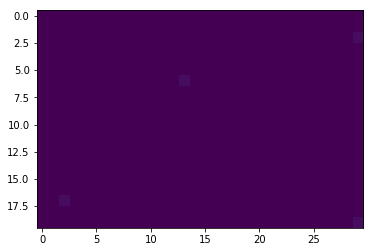

24177


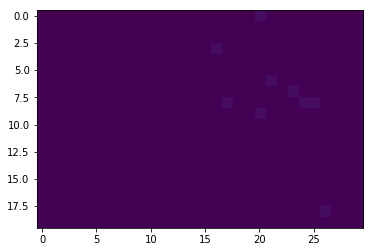

18669


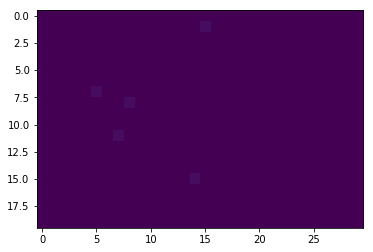

11499


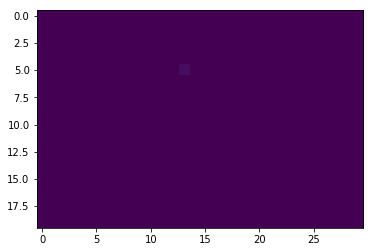

24608


In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsA]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [8]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(25000, 600)
(25000, 600)


In [9]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[20413])
# print(x_train_scaled[20413])
# print(x_test[20413])
# print(x_test_scaled[20413])

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [10]:
import keras.backend as KK
import keras.callbacks as KKcall

In [11]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [12]:
# this model maps an input to its encoded representation
encoderA = Model(input_imgA, encodedA)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputA = Input(shape=(encoding_dimA,))
# retrieve the last layer of the autoencoder model
decoder_layerA = autoencoderA.layers[-1]
# create the decoder model
decoderA = Model(encoded_inputA, decoder_layerA(encoded_inputA))

autoencoderA.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderA.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [13]:
algoritmo='RMSprop'
experimento="scaledA_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dimA,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderA.fit(x_train_scaled, x_train_scaled,
                epochs=100,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 2s 90us/step - loss: 17.2072 - energy_error: -37.4496 - val_loss: 19.2451 - val_energy_error: -32.1326
Epoch 2/100
25000/25000 [==============================] - 1s 33us/step - loss: 16.4740 - energy_error: -29.8236 - val_loss: 18.6620 - val_energy_error: -33.2672
Epoch 3/100
25000/25000 [==============================] - 1s 29us/step - loss: 15.9940 - energy_error: -29.4992 - val_loss: 18.2622 - val_energy_error: -31.8343
Epoch 4/100
25000/25000 [==============================] - 1s 32us/step - loss: 15.6447 - energy_error: -27.6045 - val_loss: 17.9632 - val_energy_error: -30.6322
Epoch 5/100
25000/25000 [==============================] - 1s 30us/step - loss: 15.3700 - energy_error: -25.9224 - val_loss: 17.7251 - val_energy_error: -29.8295
Epoch 6/100
25000/25000 [==============================] - 1s 28us/step - loss: 15.1425 - energy_error: -24.6032 - val_loss: 17.5273 - val_e

25000/25000 [==============================] - 1s 30us/step - loss: 11.8888 - energy_error: -14.4832 - val_loss: 14.8245 - val_energy_error: -25.9042
Epoch 52/100
25000/25000 [==============================] - 1s 28us/step - loss: 11.8519 - energy_error: -14.4145 - val_loss: 14.7956 - val_energy_error: -25.8698
Epoch 53/100
25000/25000 [==============================] - 1s 30us/step - loss: 11.8156 - energy_error: -14.3470 - val_loss: 14.7671 - val_energy_error: -25.8422
Epoch 54/100
25000/25000 [==============================] - 1s 29us/step - loss: 11.7798 - energy_error: -14.2810 - val_loss: 14.7391 - val_energy_error: -25.8205
Epoch 55/100
25000/25000 [==============================] - 1s 28us/step - loss: 11.7445 - energy_error: -14.2165 - val_loss: 14.7116 - val_energy_error: -25.8042
Epoch 56/100
25000/25000 [==============================] - 1s 28us/step - loss: 11.7098 - energy_error: -14.1535 - val_loss: 14.6845 - val_energy_error: -25.7911
Epoch 57/100
25000/25000 [=========

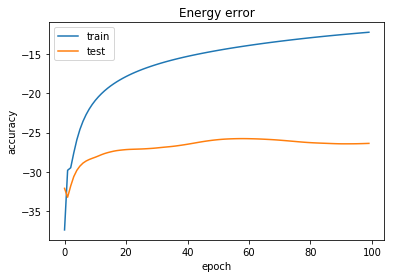

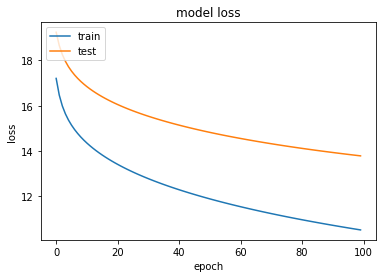

In [14]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# import pandas as pd 
# autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [16]:
autoencoderA.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimA,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [17]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [18]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoderA.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled)
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


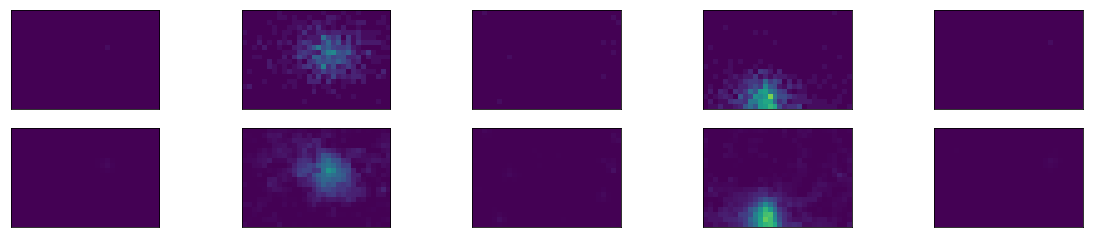

24438


In [19]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsA,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


In [20]:
x_trainB = x_trainB.reshape(x_trainB.shape[0], img_colsB, img_rows,1)
# X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
x_testB = x_testB.reshape(x_testB.shape[0], img_colsB, img_rows,1)


input_shapeB = (img_colsB, img_rows,1)
#input_shape=input_shape.astype('int32')

In [21]:
x_trainB = x_trainB.astype('float32')
# X_val= X_val.astype('float32')
x_testB = x_testB.astype('float32')

print('X_train shape:', x_trainB.shape)
# print(X_train.shape[0], 'train samples')
# print(X_val.shape[0], 'validation samples')

X_train=x_trainB
X_test=x_testB

X_train shape: (5000, 25, 20, 1)


Display 20 random training images using image

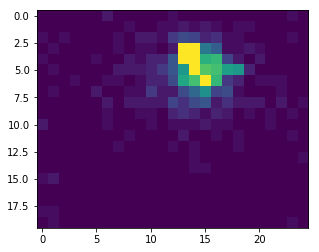

4099


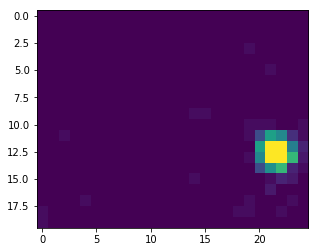

209


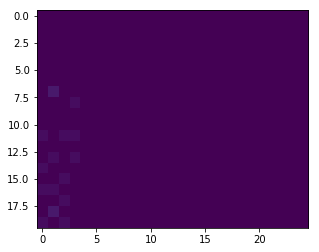

4151


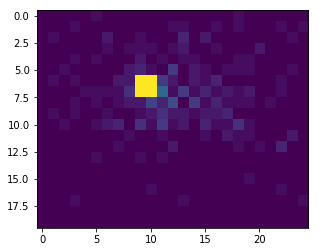

2830


In [22]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [img_rows, img_colsB]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [23]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)


(5000, 500)
(5000, 500)


In [24]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=1
factor_aprendizaje=0.0001
print(min_max_scaler)
# x_train_scaled = min_max_scaler.transform(x_train)
# x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(x_train/supermax)
x_test_scaled=(x_test/supermax)
#min_max_scaler.scale_
# print(x_train[2413])
# print(x_train_scaled[2413])
# print(x_test[2413])
# print(x_test_scaled[2413])

MinMaxScaler(copy=True, feature_range=(0, 1))


## Build the autoencoder. 

Create our metrics, for example energy

In [25]:
import keras.backend as KK
import keras.callbacks as KKcall

In [26]:
class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.sum((y_val+1)*supermax/2, axis=1)
        y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.mean(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()

def energy_error(y_true, y_pred):
    veamos_energia=(KK.sum(y_pred, axis=1)-KK.sum(y_true,axis=1))
    return KK.mean(veamos_energia,axis=-1)

In [27]:
# this model maps an input to its encoded representation
encoderB = Model(input_imgB, encodedB)

# create a placeholder for an encoded (32-dimensional) input
encoded_inputB = Input(shape=(encoding_dimB,))
# retrieve the last layer of the autoencoder model
decoder_layerB = autoencoderB.layers[-1]
# create the decoder model
decoder = Model(encoded_inputB, decoder_layerB(encoded_inputB))

autoencoderB.compile(optimizer='RMSprop', loss='mse', metrics=[energy_error])

autoencoderB.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [28]:
algoritmo='RMSprop'
experimento="scaledB_{}_encoder_without_bias_sig_sig_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}{}".format(encoding_dimB,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
results=autoencoderB.fit(x_train_scaled, x_train_scaled,
                epochs=500,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop, metrics],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 5000 samples, validate on 5000 samples
Epoch 1/500
5000/5000 [==============================] - 0s 73us/step - loss: 19.9372 - energy_error: -64.8370 - val_loss: 21.7822 - val_energy_error: -27.0414
Epoch 2/500
5000/5000 [==============================] - 0s 32us/step - loss: 19.6368 - energy_error: -26.9841 - val_loss: 21.5922 - val_energy_error: -19.0070
Epoch 3/500
5000/5000 [==============================] - 0s 27us/step - loss: 19.4386 - energy_error: -23.8138 - val_loss: 21.4189 - val_energy_error: -18.7745
Epoch 4/500
5000/5000 [==============================] - 0s 37us/step - loss: 19.2545 - energy_error: -23.8373 - val_loss: 21.2579 - val_energy_error: -19.3742
Epoch 5/500
5000/5000 [==============================] - 0s 34us/step - loss: 19.0836 - energy_error: -24.3690 - val_loss: 21.1088 - val_energy_error: -20.2241
Epoch 6/500
5000/5000 [==============================] - 0s 29us/step - loss: 18.9252 - energy_error: -25.0629 - val_loss: 20.9714 - val_energy_error: -

5000/5000 [==============================] - 0s 26us/step - loss: 15.8757 - energy_error: -20.0184 - val_loss: 18.7457 - val_energy_error: -33.4919
Epoch 52/500
5000/5000 [==============================] - 0s 25us/step - loss: 15.8379 - energy_error: -19.9157 - val_loss: 18.7231 - val_energy_error: -33.6076
Epoch 53/500
5000/5000 [==============================] - 0s 32us/step - loss: 15.8006 - energy_error: -19.8148 - val_loss: 18.7007 - val_energy_error: -33.7136
Epoch 54/500
5000/5000 [==============================] - 0s 26us/step - loss: 15.7639 - energy_error: -19.7156 - val_loss: 18.6788 - val_energy_error: -33.8092
Epoch 55/500
5000/5000 [==============================] - 0s 27us/step - loss: 15.7276 - energy_error: -19.6180 - val_loss: 18.6572 - val_energy_error: -33.8948
Epoch 56/500
5000/5000 [==============================] - 0s 26us/step - loss: 15.6918 - energy_error: -19.5220 - val_loss: 18.6359 - val_energy_error: -33.9718
Epoch 57/500
5000/5000 [=======================

Epoch 102/500
5000/5000 [==============================] - 0s 25us/step - loss: 14.3888 - energy_error: -16.3370 - val_loss: 17.9095 - val_energy_error: -34.7705
Epoch 103/500
5000/5000 [==============================] - 0s 29us/step - loss: 14.3656 - energy_error: -16.2871 - val_loss: 17.8973 - val_energy_error: -34.7595
Epoch 104/500
5000/5000 [==============================] - 0s 35us/step - loss: 14.3426 - energy_error: -16.2376 - val_loss: 17.8852 - val_energy_error: -34.7486
Epoch 105/500
5000/5000 [==============================] - 0s 27us/step - loss: 14.3197 - energy_error: -16.1887 - val_loss: 17.8732 - val_energy_error: -34.7381
Epoch 106/500
5000/5000 [==============================] - 0s 29us/step - loss: 14.2970 - energy_error: -16.1403 - val_loss: 17.8613 - val_energy_error: -34.7279
Epoch 107/500
5000/5000 [==============================] - 0s 31us/step - loss: 14.2745 - energy_error: -16.0924 - val_loss: 17.8495 - val_energy_error: -34.7185
Epoch 108/500
5000/5000 [===

5000/5000 [==============================] - 0s 28us/step - loss: 13.3813 - energy_error: -14.3590 - val_loss: 17.3909 - val_energy_error: -34.5219
Epoch 153/500
5000/5000 [==============================] - 0s 27us/step - loss: 13.3636 - energy_error: -14.3273 - val_loss: 17.3821 - val_energy_error: -34.5157
Epoch 154/500
5000/5000 [==============================] - 0s 30us/step - loss: 13.3460 - energy_error: -14.2959 - val_loss: 17.3734 - val_energy_error: -34.5103
Epoch 155/500
5000/5000 [==============================] - 0s 29us/step - loss: 13.3284 - energy_error: -14.2646 - val_loss: 17.3647 - val_energy_error: -34.5063
Epoch 156/500
5000/5000 [==============================] - 0s 28us/step - loss: 13.3109 - energy_error: -14.2334 - val_loss: 17.3561 - val_energy_error: -34.5032
Epoch 157/500
5000/5000 [==============================] - 0s 28us/step - loss: 13.2935 - energy_error: -14.2025 - val_loss: 17.3476 - val_energy_error: -34.5005
Epoch 158/500
5000/5000 [=================

5000/5000 [==============================] - 0s 25us/step - loss: 12.5765 - energy_error: -13.0099 - val_loss: 17.0044 - val_energy_error: -34.4256
Epoch 203/500
5000/5000 [==============================] - 0s 36us/step - loss: 12.5618 - energy_error: -12.9869 - val_loss: 16.9976 - val_energy_error: -34.4260
Epoch 204/500
5000/5000 [==============================] - 0s 25us/step - loss: 12.5472 - energy_error: -12.9641 - val_loss: 16.9908 - val_energy_error: -34.4261
Epoch 205/500
5000/5000 [==============================] - 0s 28us/step - loss: 12.5326 - energy_error: -12.9413 - val_loss: 16.9841 - val_energy_error: -34.4259
Epoch 206/500
5000/5000 [==============================] - 0s 27us/step - loss: 12.5181 - energy_error: -12.9188 - val_loss: 16.9774 - val_energy_error: -34.4254
Epoch 207/500
5000/5000 [==============================] - 0s 31us/step - loss: 12.5036 - energy_error: -12.8963 - val_loss: 16.9707 - val_energy_error: -34.4246
Epoch 208/500
5000/5000 [=================

5000/5000 [==============================] - 0s 27us/step - loss: 11.8928 - energy_error: -11.9855 - val_loss: 16.6941 - val_energy_error: -34.3703
Epoch 253/500
5000/5000 [==============================] - 0s 27us/step - loss: 11.8800 - energy_error: -11.9675 - val_loss: 16.6884 - val_energy_error: -34.3743
Epoch 254/500
5000/5000 [==============================] - 0s 30us/step - loss: 11.8673 - energy_error: -11.9495 - val_loss: 16.6828 - val_energy_error: -34.3775
Epoch 255/500
5000/5000 [==============================] - 0s 28us/step - loss: 11.8546 - energy_error: -11.9317 - val_loss: 16.6772 - val_energy_error: -34.3799
Epoch 256/500
5000/5000 [==============================] - 0s 27us/step - loss: 11.8420 - energy_error: -11.9140 - val_loss: 16.6716 - val_energy_error: -34.3820
Epoch 257/500
5000/5000 [==============================] - 0s 33us/step - loss: 11.8294 - energy_error: -11.8964 - val_loss: 16.6660 - val_energy_error: -34.3842
Epoch 258/500
5000/5000 [=================

5000/5000 [==============================] - 0s 27us/step - loss: 11.2925 - energy_error: -11.1544 - val_loss: 16.4405 - val_energy_error: -34.0412
Epoch 303/500
5000/5000 [==============================] - 0s 29us/step - loss: 11.2812 - energy_error: -11.1390 - val_loss: 16.4359 - val_energy_error: -34.0340
Epoch 304/500
5000/5000 [==============================] - 0s 27us/step - loss: 11.2699 - energy_error: -11.1237 - val_loss: 16.4313 - val_energy_error: -34.0239
Epoch 305/500
5000/5000 [==============================] - 0s 31us/step - loss: 11.2586 - energy_error: -11.1084 - val_loss: 16.4267 - val_energy_error: -34.0201
Epoch 306/500
5000/5000 [==============================] - 0s 29us/step - loss: 11.2473 - energy_error: -11.0932 - val_loss: 16.4221 - val_energy_error: -34.0115
Epoch 307/500
5000/5000 [==============================] - 0s 28us/step - loss: 11.2361 - energy_error: -11.0780 - val_loss: 16.4175 - val_energy_error: -34.0089
Epoch 308/500
5000/5000 [=================

5000/5000 [==============================] - 0s 25us/step - loss: 10.7549 - energy_error: -10.4037 - val_loss: 16.2203 - val_energy_error: -33.7185
Epoch 353/500
5000/5000 [==============================] - 0s 27us/step - loss: 10.7447 - energy_error: -10.3940 - val_loss: 16.2170 - val_energy_error: -35.1281
Epoch 354/500
5000/5000 [==============================] - 0s 33us/step - loss: 10.7345 - energy_error: -10.4985 - val_loss: 16.2113 - val_energy_error: -31.3448
Epoch 355/500
5000/5000 [==============================] - 0s 26us/step - loss: 10.7244 - energy_error: -10.3096 - val_loss: 16.2092 - val_energy_error: -35.5860
Epoch 356/500
5000/5000 [==============================] - 0s 30us/step - loss: 10.7142 - energy_error: -10.4385 - val_loss: 16.2039 - val_energy_error: -32.7746
Epoch 357/500
5000/5000 [==============================] - 0s 32us/step - loss: 10.7041 - energy_error: -10.3817 - val_loss: 16.1997 - val_energy_error: -32.6581
Epoch 358/500
5000/5000 [=================

Epoch 403/500
5000/5000 [==============================] - 0s 28us/step - loss: 10.2577 - energy_error: -9.7621 - val_loss: 16.0357 - val_energy_error: -35.5845
Epoch 404/500
5000/5000 [==============================] - 0s 31us/step - loss: 10.2484 - energy_error: -9.9123 - val_loss: 16.0302 - val_energy_error: -30.3829
Epoch 405/500
5000/5000 [==============================] - 0s 25us/step - loss: 10.2393 - energy_error: -9.6611 - val_loss: 16.0289 - val_energy_error: -35.6823
Epoch 406/500
5000/5000 [==============================] - 0s 27us/step - loss: 10.2298 - energy_error: -9.8361 - val_loss: 16.0241 - val_energy_error: -32.0784
Epoch 407/500
5000/5000 [==============================] - 0s 33us/step - loss: 10.2207 - energy_error: -9.7552 - val_loss: 16.0207 - val_energy_error: -32.6366
Epoch 408/500
5000/5000 [==============================] - 0s 29us/step - loss: 10.2114 - energy_error: -9.6486 - val_loss: 16.0195 - val_energy_error: -36.8947
Epoch 409/500
5000/5000 [=========

5000/5000 [==============================] - 0s 26us/step - loss: 9.8024 - energy_error: -9.3655 - val_loss: 15.8728 - val_energy_error: -31.3204
Epoch 455/500
5000/5000 [==============================] - 0s 27us/step - loss: 9.7941 - energy_error: -9.1634 - val_loss: 15.8707 - val_energy_error: -34.0822
Epoch 456/500
5000/5000 [==============================] - 0s 30us/step - loss: 9.7853 - energy_error: -9.2386 - val_loss: 15.8682 - val_energy_error: -33.7302
Epoch 457/500
5000/5000 [==============================] - 0s 28us/step - loss: 9.7769 - energy_error: -9.2438 - val_loss: 15.8649 - val_energy_error: -33.4100
Epoch 458/500
5000/5000 [==============================] - 0s 26us/step - loss: 9.7684 - energy_error: -9.1564 - val_loss: 15.8621 - val_energy_error: -34.3652
Epoch 459/500
5000/5000 [==============================] - 0s 28us/step - loss: 9.7597 - energy_error: -9.3249 - val_loss: 15.8572 - val_energy_error: -28.9131
Epoch 460/500
5000/5000 [=============================

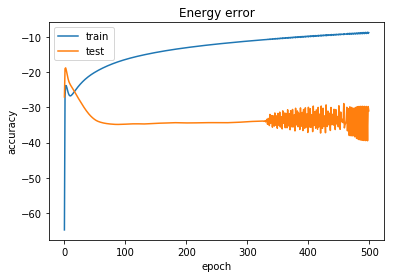

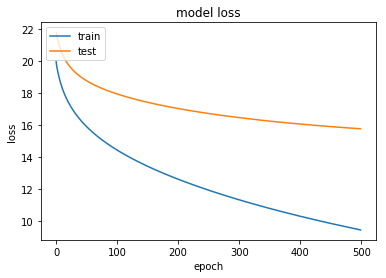

In [29]:
# summarize history for categorical accuracy
plt.plot(results.history['energy_error'])
plt.plot(results.history['val_energy_error'])
plt.title('Energy error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# import pandas as pd 
# autoencoderB.evaluate(x=x_test_scaled,y=x_test_scaled)
# D=metrics.get_data()


# energies=pd.DataFrame(D).values.reshape(len(D))
# valores=len(energies)
# plt.plot(range(valores),energies) 

# plt.show()

In [31]:
autoencoderB.save_weights('../redes_compresoras/defs/compresor_python_{}{}{}{}'.format(encoding_dimB,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)
#autoencoder.load_weights('../redes_compresoras/defs/compresor_python_320RMSpropscaled_100_encoder_without_bias_sig_sig_lr_0.00012018-11-03 09:43:55.047213')

In [32]:
# standard_scores = encoder.predict(x_test_scaled).ravel()
# #regularized_scores = encoded_regularized.predict(x_test).ravel()
# sns.distplot(standard_scores, hist=True, label='standard model')
# #sns.distplot(regularized_scores, hist=False, label='regularized model')

In [33]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
# decoded_imgs_scaled = autoencoderB.predict(x_test_min_max)
decoded_imgs_scaledB = autoencoderB.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaledB)
# decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


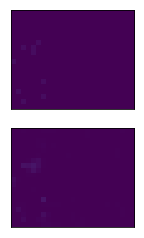

In [34]:
n = 1  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsB,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [35]:
x_total=conjunto_datos[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)

Veamos ahora ciertos estudios

In [36]:
photodefbox2_todo_fil1= datos_matlab.get('photodefbox2_todo_fil1')
numero_muestras=photodefbox2_todo_fil1.shape[0]
x_total=photodefbox2_todo_fil1[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil1_e=np.concatenate((photodefbox2_todo_fil1,mse_idea),axis=1)

In [37]:
photodefbox2_todo_fil2= datos_matlab.get('photodefbox2_todo_fil2')

In [38]:
numero_muestras=photodefbox2_todo_fil2.shape[0]
x_total=photodefbox2_todo_fil2[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil2_e=np.concatenate((photodefbox2_todo_fil2,mse_idea),axis=1)

In [39]:
photodefbox2_todo_fil3= datos_matlab.get('photodefbox2_todo_fil3')
numero_muestras=photodefbox2_todo_fil3.shape[0]
x_total=photodefbox2_todo_fil3[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil3_e=np.concatenate((photodefbox2_todo_fil3,mse_idea),axis=1)

In [40]:
photodefbox2_todo_fil4= datos_matlab.get('photodefbox2_todo_fil4')
numero_muestras=photodefbox2_todo_fil4.shape[0]
x_total=photodefbox2_todo_fil4[0:numero_muestras,:]
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
img_rows=20
img_colsA=30
img_colsB=25
img_cols=30
input_output_dim_A=img_rows*img_colsA
input_output_dim_B=img_rows*img_colsB
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_total[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_total.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_total.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_total[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
#     entrada_imgs_A=(ideaA) #he quitado el escalado
#     encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
#     decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
#     #print(decoded_imgs_A.shape)
#     #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
#     salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    


    ideaA_scaled=(ideaA/(supermax))
    salida_reconstructed_1_scaled = autoencoderA.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled)
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_total[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
    #entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
#     entrada_imgs_B=(ideaB)  #quito el escalado
#     encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
#     decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)
#     salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso  
    ideaB_scaled=(ideaB/(supermax))
    salida_reconstructed_2_scaled = autoencoderB.predict(ideaB_scaled)    
    salida_reconstructed_2 = supermax*(salida_reconstructed_2_scaled)
    #salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
  
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
    
mse = (np.square(cara_externa - cara_externa_reconstruida)).mean(axis=1)
mse.shape[0]
mse_idea=np.reshape(mse,(mse.shape[0],1))
photodefbox2_todo_fil4_e=np.concatenate((photodefbox2_todo_fil4,mse_idea),axis=1)

In [62]:
veamosd1 =np.concatenate((photodefbox2_todo_fil1_e[:,-9],photodefbox2_todo_fil2_e[:,-9]),axis=0);
veamosd2 =np.concatenate((photodefbox2_todo_fil3_e[:,-4],photodefbox2_todo_fil4_e[:,-4]),axis=0);
veamosd3 =np.concatenate((photodefbox2_todo_fil3_e[:,-9],photodefbox2_todo_fil4_e[:,-9]),axis=0);

distancias=np.concatenate((veamosd1,veamosd2,veamosd3));

In [61]:
veamosen1 =np.concatenate((photodefbox2_todo_fil1_e[:,-11],photodefbox2_todo_fil2_e[:,-11]),axis=0);
veamosen2 =np.concatenate((photodefbox2_todo_fil3_e[:,-6],photodefbox2_todo_fil4_e[:,-6]),axis=0);
veamosen3 =np.concatenate((photodefbox2_todo_fil3_e[:,-11],photodefbox2_todo_fil4_e[:,-11]),axis=0);

energias=np.concatenate((veamosen1,veamosen2,veamosen3));

In [71]:
veamoser1=np.concatenate((photodefbox2_todo_fil1_e[:,-1],photodefbox2_todo_fil2_e[:,-1]),axis=0);
veamoser2 =np.concatenate((photodefbox2_todo_fil3_e[:,-1],photodefbox2_todo_fil4_e[:,-1]),axis=0);
veamoser3 =np.concatenate((photodefbox2_todo_fil3_e[:,-1],photodefbox2_todo_fil4_e[:,-1]),axis=0);

errores=np.concatenate((veamoser1,veamoser2/2,veamoser3/2));

In [70]:
veamosft1=np.concatenate((np.sum(photodefbox2_todo_fil1_e[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B],axis=1),np.sum(photodefbox2_todo_fil2_e[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B],axis=1)), axis=0);
veamosft2=np.concatenate((np.sum(photodefbox2_todo_fil3_e[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B],axis=1),np.sum(photodefbox2_todo_fil4_e[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B],axis=1)), axis=0);
veamosft3=np.concatenate((np.sum(photodefbox2_todo_fil3_e[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B],axis=1),np.sum(photodefbox2_todo_fil4_e[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B],axis=1)), axis=0);


fotones=np.concatenate((veamosft1,veamosft2/2,veamosft3/2));




Veamos ahora los histogramnas 2d que nos interesan

In [ ]:
plt.figure(figsize=(20, 8))
plt.hist(errores, bins=100, range=(0,10))
plt.show()
plt.figure(figsize=(20, 8))
h=plt.hist2d(energias, distancias, bins=40,range=[(0,0.5),(0,0.8)])
plt.colorbar(h[3], ax=ax)
plt.show()
plt.figure(figsize=(20, 8))
plt.hist2d(errores,distancias, bins=40, range=[(0,1),(0,0.8)])
plt.show()
plt.figure(figsize=(20, 8))
plt.hist2d(errores,energias, bins=40, range=[(0,1),(0,0.5)])
plt.show()

## Visualizamos los resultados

Visualizamos todos los sensores: 

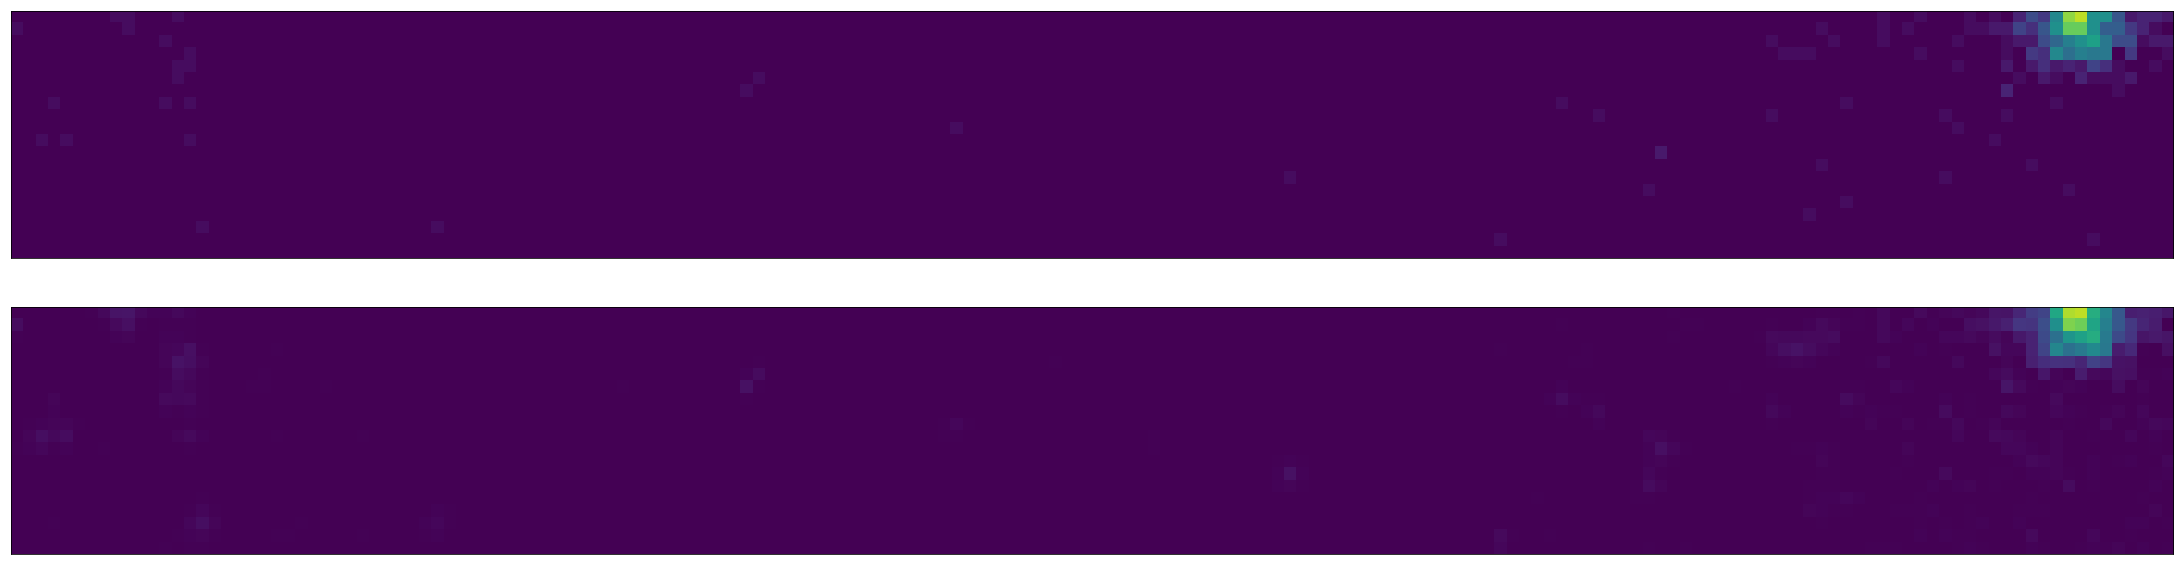

In [48]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

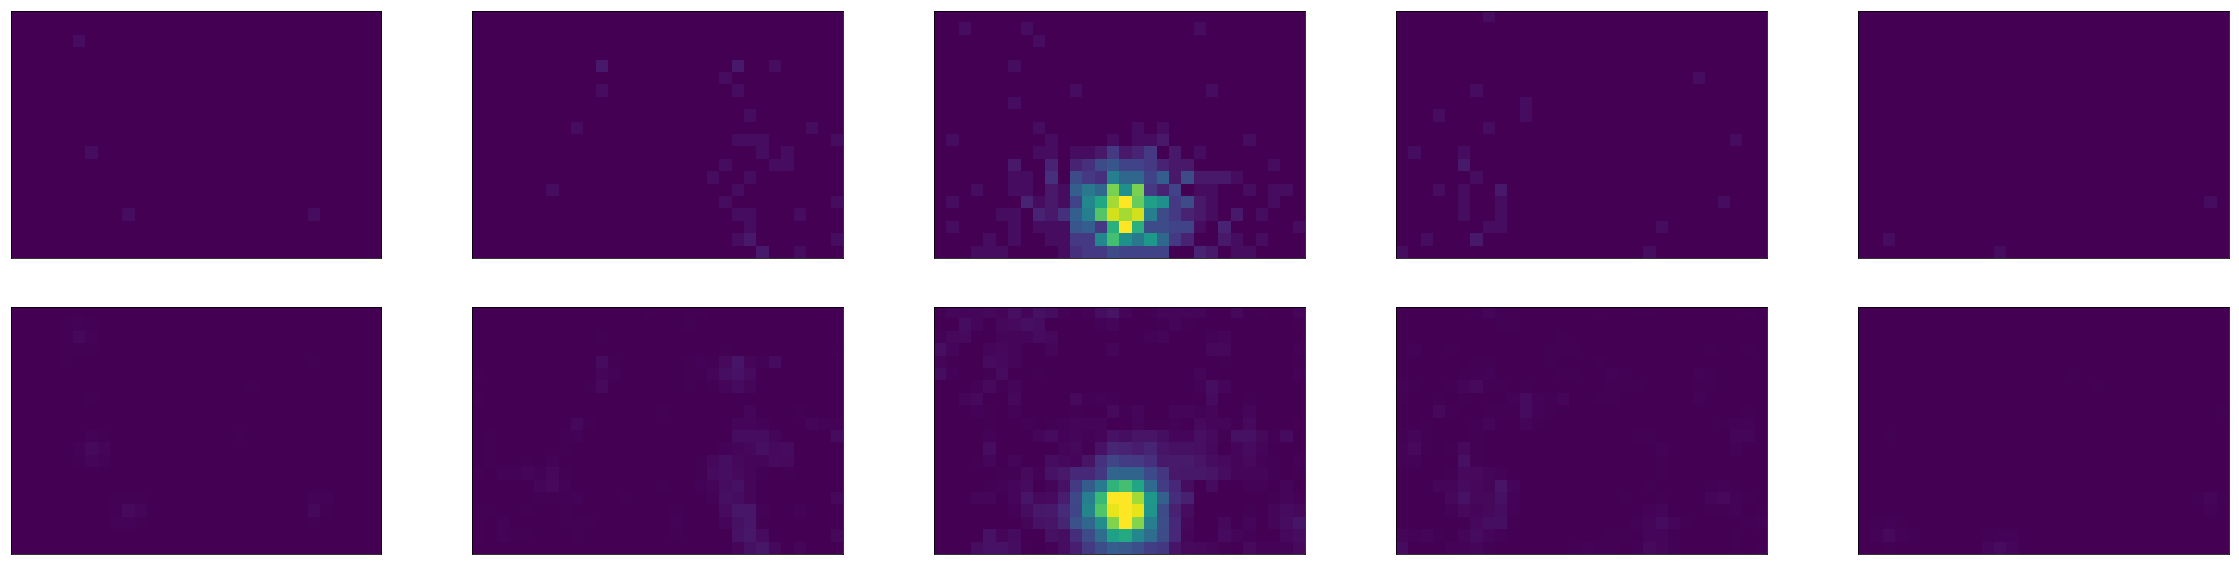

In [44]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

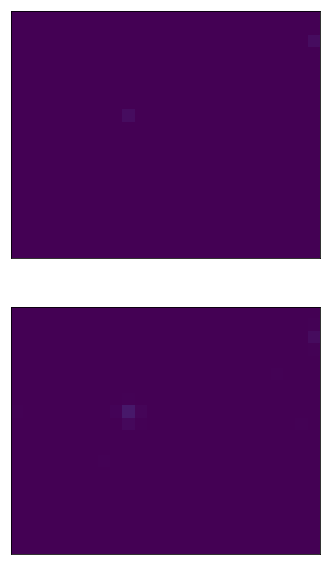

3825


In [45]:
n = L1B  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [46]:
print(idea)
np.sum(cara_externa_reconstruida,axis=0)

3825


array([7181.65290511, 8405.31127744, 9245.32312413, ..., 9100.8306224 ,
       9611.33371257, 7381.36538177])

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


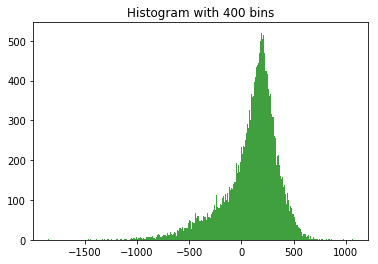

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 400
    # variables        = 3
    chi-square         = 296727.717
    reduced chi-square = 747.424979
    Akaike info crit   = 2649.64227
    Bayesian info crit = 2661.61666
[[Variables]]
    amp:  423.608500 +/- 5.30600566 (1.25%) (init = 200)
    cen:  170.323278 +/- 2.36752456 (1.39%) (init = 0)
    wid:  231.480655 +/- 3.34818533 (1.45%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



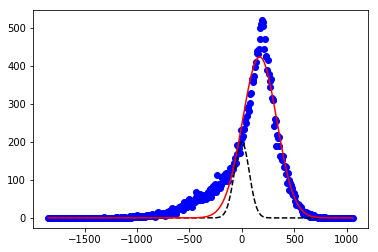

In [47]:
veamos_energia=(np.sum(cara_externa_reconstruida, axis=1))-(np.sum(cara_externa, axis=1))
n, bins, patches = plt.hist(veamos_energia, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=200, cen=0, wid=100)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()